In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd /content/drive/MyDrive/forimagedetect/

/content/drive/MyDrive/forimagedetect


In [4]:
!pip install torchinfo
!pip install torchvision
!pip install tqdm


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [5]:
import warnings
warnings.filterwarnings(action = "ignore")

import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from torch import nn,optim
from torchinfo import summary
from torchvision.models import efficientnet_b0

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as F

from sklearn.metrics import accuracy_score
import sys
mod = sys.modules[__name__]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
class resize_with_pad:
    def __init__(self, w=224, h=224):
        self.w = w
        self.h = h
        self.resize = transforms.Resize(size=(self.h, self.w))

    def __call__(self, image):

        img_w, img_h = image.size
        ratio_f = self.w / self.h
        img_ratio = img_w / img_h

        if round(img_ratio, 2) != round(ratio_f, 2):

            hp = int(img_w/ratio_f - img_h)
            wp = int(ratio_f * img_h - img_w)
            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                return F.resize(image, [self.h, self.w])

            elif hp < 0 and wp > 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                return F.resize(image, [self.h, self.w])

        else:
            return F.resize(image, [self.h, self.w])

In [7]:

class PretrainModel(nn.Module):
    def __init__(self, pretrained_model_name, n_classes:int):
        super().__init__()
        self.pretrained_name = pretrained_model_name
        self.pretrained_model = getattr(mod, pretrained_model_name)(pretrained = True)
        self.pretrained_model.classifier = nn.Sequential(
            nn.Dropout(p = 0.2, inplace=True),
            nn.Linear(self.pretrained_model.classifier[1].in_features, n_classes),
        )


    def forward(self, x):
        x = self.pretrained_model(x)
        return x

In [8]:

transform = transforms.Compose([
    resize_with_pad(),
    transforms.ToTensor(),
])

dataset = ImageFolder(root = "./data", transform = transform)
dataset.class_to_idx

{'nostair': 0, 'stair': 1}

In [9]:
SEED = 88
TEST_RATIO = 0.2

BATCH_SIZE = 32
N_CLASS = 2
EPOCHS = 10000

LR = 0.00007
LABEL_SMOOTHING = 0.1
VERBOSE = True

In [10]:
transform = transforms.Compose([
    resize_with_pad(),
    transforms.ToTensor(),
])

In [11]:
dataset = ImageFolder(root = "./data", transform = transform)
dataset.class_to_idx

{'nostair': 0, 'stair': 1}

In [12]:
from torch.utils.data import DataLoader, random_split

generator = torch.Generator()
generator.manual_seed(SEED)

dataset_size = len(dataset)
train_size = int(dataset_size * (1 - TEST_RATIO))
test_size = dataset_size - train_size

val_size = int(train_size * TEST_RATIO)
train_size = train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator)

# Confirm
print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(val_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

# DataLoader
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Training Data Size : 1297
Validation Data Size : 324
Testing Data Size : 406


In [13]:
class EarlyStopping:
    def __init__(self, patience = 5, thresh = 0.0, mode = "min", verbose = True):
        self.early_stop = False
        self.patience = patience
        self.verbose = verbose
        self.mode = mode
        self.thresh = thresh

        self.counter = 0
        self.best_score = np.Inf if mode == "min" else 0 if mode == "max" else AssertionError

    def step(self, score):
        if self.mode == "min":
            if score < (self.best_score - self.thresh):
                self.counter = 0
                self.best_score = score
            else:
                self.counter += 1
                if self.verbose:
                    print(f"[EarlyStopping] (Patience) {self.counter}/{self.patience}. "\
                          f"Best score: {self.best_score:.5f}"\
                          f", Current: {score:.5f}")


        elif self.mode == "max":
            if score > (self.best_score + self.thresh):
                self.counter = 0
                self.best_score = score
                if self.verbose:
                    print(f"[EarlyStopping] (Patience) {self.counter}/{self.patience}. "\
                          f"Best score: {self.best_score:.5f}"\
                          f", Current: {score:.5f}")

        if self.counter >= self.patience:
            if self.verbose:
                print(f"[EarlyStop Triggered] Best Score: {self.best_score:.5f}")

            #Early stop
            self.early_stop = True

In [14]:
pretrained_model_name_list = [
    "efficientnet_b0"
    ]

In [15]:



transform_to_tensor = transforms.ToTensor()
def loss_epoch(model, data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in data_loader:
        inputs = transform_to_tensor(inputs)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)

    return epoch_loss, epoch_acc.item(), preds



In [16]:
def loss_epoch(model, DL, criterion, optimizer = None):
    N = len(DL.dataset)
    rloss = 0; rcorrect = 0
    for x_batch, y_batch in tqdm(DL, leave=False):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        y_hat = model(x_batch)

        loss = criterion(y_hat, y_batch)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_b = loss.item() * x_batch.shape[0]
        rloss += loss_b

        pred = y_hat.argmax(dim=1)
        corrects_b = torch.sum(pred == y_batch).item()
        rcorrect += corrects_b
    loss_e = rloss/ N
    accuracy_e = rcorrect/N*100

    return loss_e, accuracy_e, rcorrect

In [20]:
for pretrained_model_name in pretrained_model_name_list:
    print(pretrained_model_name)

    #Load model
    model = PretrainModel(pretrained_model_name, n_classes = N_CLASS)
    model = model.to(DEVICE)

    # Load object for training
    optimizer = optim.Adam(model.parameters(), lr = LR)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.1, patience = 10, cooldown = 3)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience = 30, thresh = 0, mode = "min")

    best_loss = np.Inf
    loss_history = {"train":[], "val":[]}
    acc_history = {"train":[], "val":[]}

    for epoch in range(EPOCHS):
        epoch_start = time.time()
        train_loss_r = 0; train_correct_r = 0
        val_loss_r = 0; val_correct_r = 0
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch: {epoch+1}, current_LR = {current_lr}")

        model.train()
        train_loss, train_acc, _ = loss_epoch(model, train_loader, criterion, optimizer)
        loss_history["train"].append(train_loss)
        acc_history["train"].append(train_acc)

        model.eval()
        with torch.no_grad():
            val_loss, val_acc, _ = loss_epoch(model, val_loader, criterion)
            loss_history["val"].append(val_loss)
            acc_history["val"].append(val_acc)

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({
                    "model" : model,
                    "epoch" : epoch,
                    "optimizer" : optimizer,
                    "scheduler" : lr_scheduler,
                            }, f"./pytorch_checkpoint/{pretrained_model_name}.pt")


            print(f"train loss: {round(train_loss,5)}, "
                f"val loss: {round(val_loss,5)} \n"
                f"train acc: {round(train_acc,1)} %, "
                f"val acc: {round(val_acc,1)} %, time: {round(time.time()-epoch_start)} s")
            print("-"*20)

        lr_scheduler.step(val_loss, epoch)

        early_stopping.step(val_loss)
        if early_stopping.early_stop:
            break

efficientnet_b0
Epoch: 1, current_LR = 7e-05


train loss: 0.5466, val loss: 0.34541 
train acc: 76.3 %, val acc: 92.0 %, time: 64 s
--------------------
Epoch: 2, current_LR = 7e-05


train loss: 0.26658, val loss: 0.19641 
train acc: 92.6 %, val acc: 94.1 %, time: 18 s
--------------------
Epoch: 3, current_LR = 7e-05


train loss: 0.14153, val loss: 0.1492 
train acc: 96.4 %, val acc: 95.7 %, time: 17 s
--------------------
Epoch: 4, current_LR = 7e-05


train loss: 0.10151, val loss: 0.15888 
train acc: 96.8 %, val acc: 94.4 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 1/30. Best score: 0.14920, Current: 0.15888
Epoch: 5, current_LR = 7e-05


train loss: 0.05566, val loss: 0.14607 
train acc: 98.6 %, val acc: 95.1 %, time: 17 s
--------------------
Epoch: 6, current_LR = 7e-05


train loss: 0.03827, val loss: 0.16039 
train acc: 99.0 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 1/30. Best score: 0.14607, Current: 0.16039
Epoch: 7, current_LR = 7e-05


train loss: 0.03008, val loss: 0.20052 
train acc: 99.2 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 2/30. Best score: 0.14607, Current: 0.20052
Epoch: 8, current_LR = 7e-05


train loss: 0.01925, val loss: 0.16981 
train acc: 99.6 %, val acc: 94.4 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 3/30. Best score: 0.14607, Current: 0.16981
Epoch: 9, current_LR = 7e-05


train loss: 0.01555, val loss: 0.2043 
train acc: 99.7 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 4/30. Best score: 0.14607, Current: 0.20430
Epoch: 10, current_LR = 7e-05


train loss: 0.01731, val loss: 0.17703 
train acc: 99.6 %, val acc: 95.4 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 5/30. Best score: 0.14607, Current: 0.17703
Epoch: 11, current_LR = 7e-05


train loss: 0.01514, val loss: 0.20148 
train acc: 99.5 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 6/30. Best score: 0.14607, Current: 0.20148
Epoch: 12, current_LR = 7e-05


train loss: 0.01297, val loss: 0.20863 
train acc: 99.7 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 7/30. Best score: 0.14607, Current: 0.20863
Epoch: 13, current_LR = 7e-05


train loss: 0.00826, val loss: 0.21085 
train acc: 99.8 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 8/30. Best score: 0.14607, Current: 0.21085
Epoch: 14, current_LR = 7e-05


train loss: 0.01295, val loss: 0.20707 
train acc: 99.5 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 9/30. Best score: 0.14607, Current: 0.20707
Epoch: 15, current_LR = 7e-05


train loss: 0.01158, val loss: 0.18836 
train acc: 99.5 %, val acc: 94.4 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 10/30. Best score: 0.14607, Current: 0.18836
Epoch: 16, current_LR = 7e-05


train loss: 0.00917, val loss: 0.20513 
train acc: 99.8 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 11/30. Best score: 0.14607, Current: 0.20513
Epoch: 17, current_LR = 7e-06


train loss: 0.00872, val loss: 0.19944 
train acc: 99.8 %, val acc: 93.5 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 12/30. Best score: 0.14607, Current: 0.19944
Epoch: 18, current_LR = 7e-06


train loss: 0.00814, val loss: 0.19226 
train acc: 99.8 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 13/30. Best score: 0.14607, Current: 0.19226
Epoch: 19, current_LR = 7e-06


train loss: 0.00558, val loss: 0.22122 
train acc: 99.9 %, val acc: 93.5 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 14/30. Best score: 0.14607, Current: 0.22122
Epoch: 20, current_LR = 7e-06


train loss: 0.0052, val loss: 0.2143 
train acc: 100.0 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 15/30. Best score: 0.14607, Current: 0.21430
Epoch: 21, current_LR = 7e-06


train loss: 0.00568, val loss: 0.22284 
train acc: 99.9 %, val acc: 93.5 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 16/30. Best score: 0.14607, Current: 0.22284
Epoch: 22, current_LR = 7e-06


train loss: 0.00442, val loss: 0.2117 
train acc: 100.0 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 17/30. Best score: 0.14607, Current: 0.21170
Epoch: 23, current_LR = 7e-06


train loss: 0.0054, val loss: 0.25038 
train acc: 99.9 %, val acc: 92.9 %, time: 18 s
--------------------
[EarlyStopping] (Patience) 18/30. Best score: 0.14607, Current: 0.25038
Epoch: 24, current_LR = 7e-06


train loss: 0.0039, val loss: 0.20563 
train acc: 99.9 %, val acc: 94.1 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 19/30. Best score: 0.14607, Current: 0.20563
Epoch: 25, current_LR = 7e-06


train loss: 0.00544, val loss: 0.2282 
train acc: 99.8 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 20/30. Best score: 0.14607, Current: 0.22820
Epoch: 26, current_LR = 7e-06


train loss: 0.00441, val loss: 0.19252 
train acc: 99.9 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 21/30. Best score: 0.14607, Current: 0.19252
Epoch: 27, current_LR = 7e-06


train loss: 0.00698, val loss: 0.22889 
train acc: 99.9 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 22/30. Best score: 0.14607, Current: 0.22889
Epoch: 28, current_LR = 7e-06


train loss: 0.00408, val loss: 0.2441 
train acc: 99.9 %, val acc: 93.5 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 23/30. Best score: 0.14607, Current: 0.24410
Epoch: 29, current_LR = 7e-06


train loss: 0.0057, val loss: 0.23529 
train acc: 99.8 %, val acc: 93.5 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 24/30. Best score: 0.14607, Current: 0.23529
Epoch: 30, current_LR = 7e-06


train loss: 0.00482, val loss: 0.21141 
train acc: 100.0 %, val acc: 94.4 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 25/30. Best score: 0.14607, Current: 0.21141
Epoch: 31, current_LR = 7.000000000000001e-07


train loss: 0.0054, val loss: 0.21588 
train acc: 100.0 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 26/30. Best score: 0.14607, Current: 0.21588
Epoch: 32, current_LR = 7.000000000000001e-07


train loss: 0.00413, val loss: 0.22678 
train acc: 100.0 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 27/30. Best score: 0.14607, Current: 0.22678
Epoch: 33, current_LR = 7.000000000000001e-07


train loss: 0.00578, val loss: 0.21766 
train acc: 99.8 %, val acc: 93.8 %, time: 17 s
--------------------
[EarlyStopping] (Patience) 28/30. Best score: 0.14607, Current: 0.21766
Epoch: 34, current_LR = 7.000000000000001e-07


train loss: 0.00658, val loss: 0.20238 
train acc: 99.8 %, val acc: 94.1 %, time: 21 s
--------------------
[EarlyStopping] (Patience) 29/30. Best score: 0.14607, Current: 0.20238
Epoch: 35, current_LR = 7.000000000000001e-07


train loss: 0.00379, val loss: 0.20663 
train acc: 100.0 %, val acc: 94.4 %, time: 18 s
--------------------
[EarlyStopping] (Patience) 30/30. Best score: 0.14607, Current: 0.20663
[EarlyStop Triggered] Best Score: 0.14607


In [21]:
def draw_history(train_loss_list, val_loss_list, title):
    assert len(train_loss_list) == len(val_loss_list)
    if len(train_loss_list) < 2:
        return None
    train_loss_x_list = np.arange(0, len(train_loss_list), 1)
    val_loss_x_list = np.arange(0, len(val_loss_list), 1)
    plt.figure(figsize = (20, 10))
    plt.plot(train_loss_x_list, train_loss_list, label = f"train {title}")
    plt.plot(val_loss_x_list, val_loss_list, label = f"val {title}")
    plt.title(title)
    plt.show()

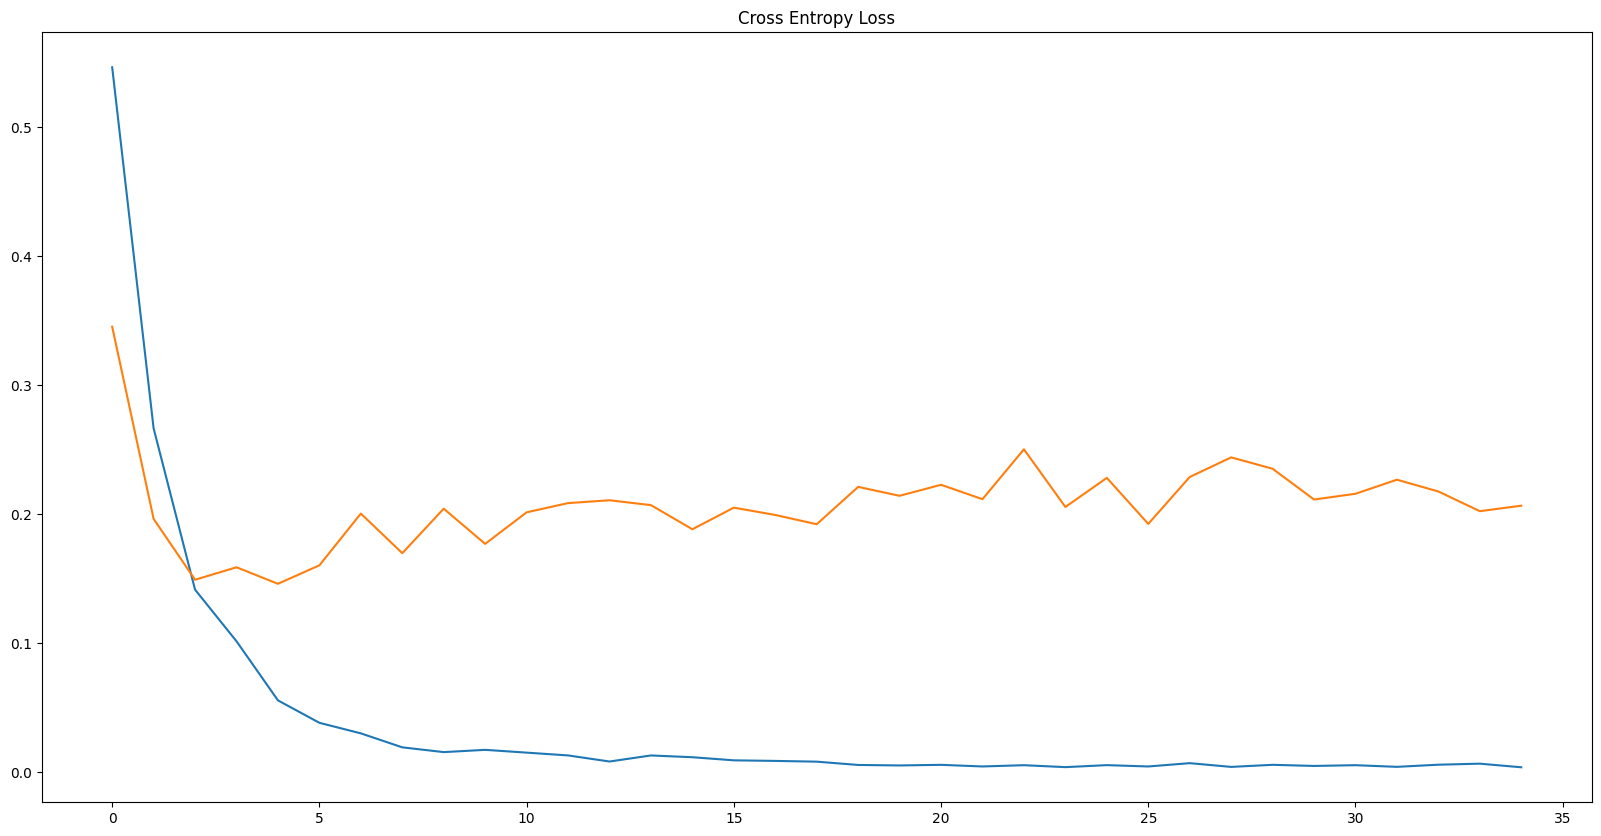

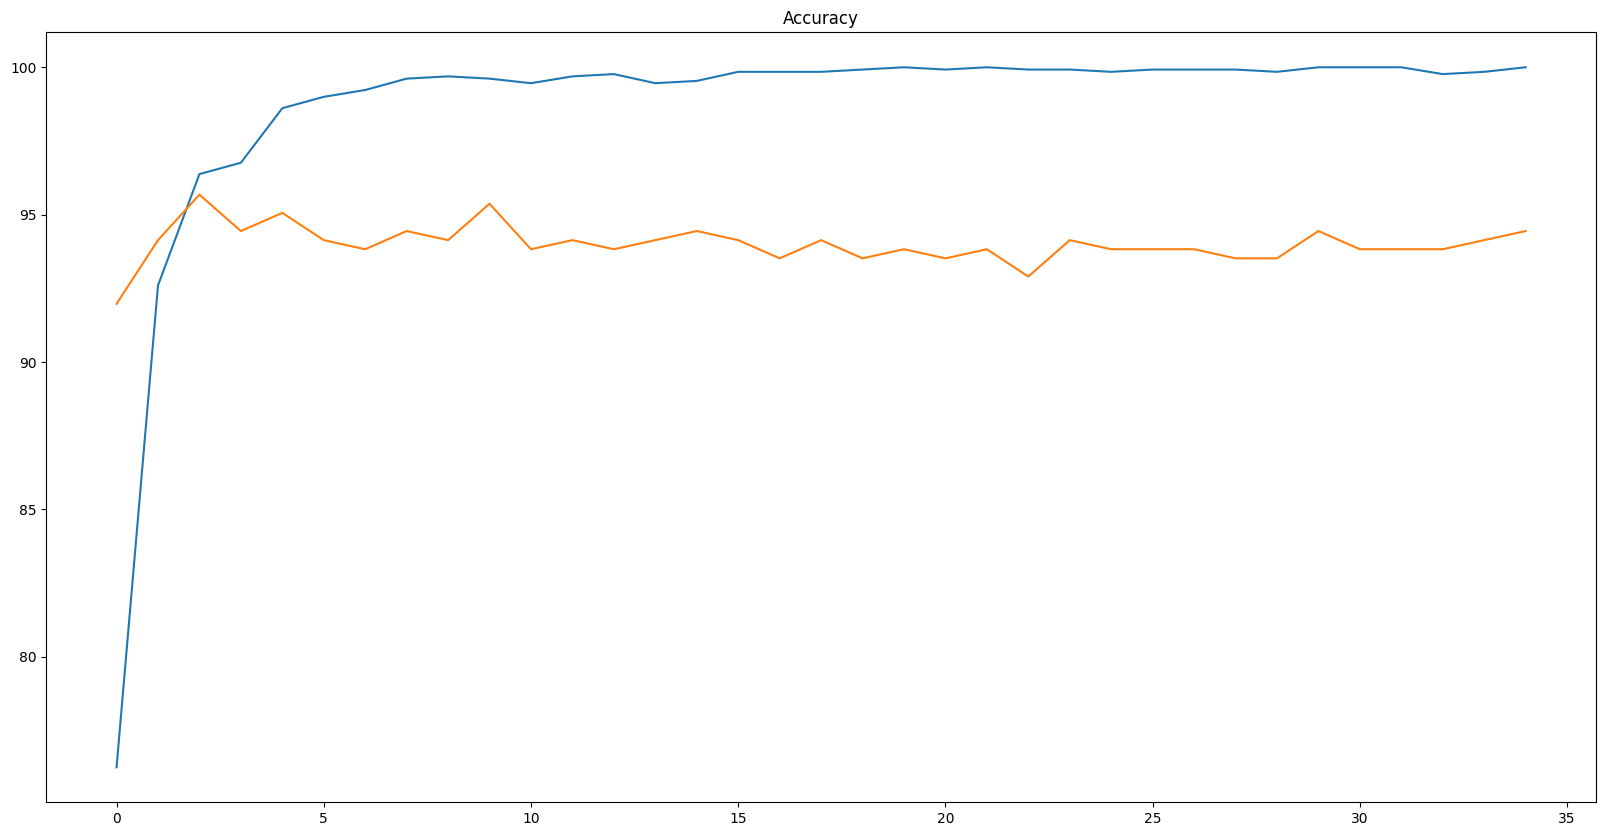

In [22]:
draw_history(loss_history["train"], loss_history["val"], title = "Cross Entropy Loss")
draw_history(acc_history["train"], acc_history["val"], title = "Accuracy")

In [24]:
loaded_model = torch.load("./pytorch_checkpoint/efficientnet_b0.pt")

In [25]:
correct = 0
for batch_imgs, batch_labels in test_loader:
    batch_imgs = batch_imgs.to(DEVICE)
    batch_labels = batch_labels.to(DEVICE)

    y_hat = loaded_model["model"](batch_imgs)
    y_pred = y_hat.argmax(dim = 1)
    correct += torch.sum(y_pred == batch_labels).item()

print((correct / len(test_loader.dataset)) * 100)

95.8128078817734
